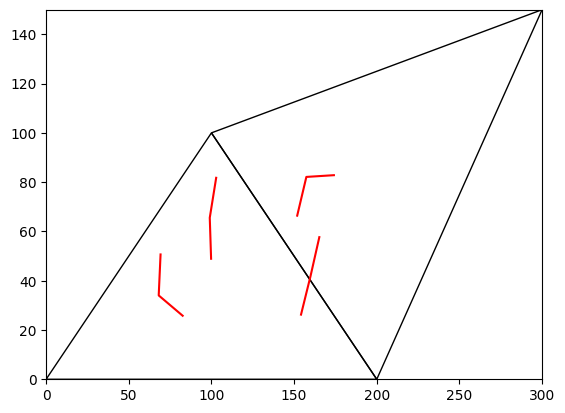

(array([[[-1.24219866e-01, -2.63161022e-02, -3.11451362e-01,
          -9.02946460e+01, -3.68844949e+02, -4.98951080e+00],
         [-8.71008331e-02, -2.10110426e-01, -1.07676985e-01,
          -9.65952002e+01, -3.69349153e+02,  2.98372581e+00],
         [-6.68201870e-01, -4.24651749e-01, -7.06262517e-02,
          -2.50205851e+02, -8.98248283e+01,  1.41186383e+01]],
 
        [[-2.68010205e-02, -7.09398687e-01, -1.80747446e-01,
          -1.12456586e+02, -3.49293363e+02, -1.82384179e+01],
         [-7.08138912e-01, -9.60900516e-02, -1.71671311e-02,
          -2.02627886e+02, -2.35949532e+01,  5.65923063e+01],
         [-4.99997444e-01,  3.76180773e-02,  6.26967961e-03,
          -1.32947974e+02,  1.08194020e+01,  7.45402123e+01]],
 
        [[ 1.06384730e-01,  6.35542614e-02,  5.23683276e-03,
           1.33781866e+02,  3.05595470e+01, -9.33412396e-01],
         [ 8.09329725e-01, -2.92905636e-03, -6.77867422e-02,
           2.19112522e+02, -9.71679103e+01,  3.37908843e+01],
         [

In [1]:
import src.TrainSetGen2 as trainSG
import src.Config as cf
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np

def plot(lines):     
    fig, ax = plt.subplots()
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 150)
    ax.add_patch(Polygon([cf.vertex1, cf.vertex2, cf.vertex3], fill=False))
    ax.add_patch(Polygon([cf.vertex3, cf.vertex2, cf.vertex4], fill=False))

    # Plot the lines
    for i in range(len(lines_a)):
        line = lines[i]
        ax.plot([point[0] for point in line], [point[1]
                for point in line], "r")

    plt.show()

[lines_a, lines_b, w, doppler] = trainSG.getLinesAndRawFeatures()
plot(lines=lines_a)

[features, labels] = trainSG.getFeaturesAndLabels(lines_a, w, doppler)

features, labels

In [ ]:
# import os
# import time

# current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
# result_folder = "results/" + current_time
# os.makedirs(result_folder)

# training_results_folder = result_folder + "/training"
# os.makedirs(training_results_folder)

# testing_results_folder= result_folder + "/testing"
# os.makedirs(testing_results_folder)


In [ ]:
# 定义更深的神经网络模型
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from IPython.display import clear_output

import src.Config as cf
import src.TrajectoryDataset as TrajectoryDataset

import src.UavModel as UavModel
using_model = UavModel.UavModel()

# 创建训练和测试数据集
train_dataset = TrajectoryDataset.TrajectoryDataset(features, labels)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=cf.train_batch_size, shuffle=True)

# 使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = using_model.to(device)

for param in model.parameters():
    print(type(param), param.size())

# 损失函数和优化器s
optimizer = optim.Adam(model.parameters(), lr=cf.learning_rate)
criterion = nn.MSELoss()

# 训练模型
loss_values = []  # 存储损失值以供绘图

for epoch in range(cf.epoch):
    for inputs, coords in train_loader:
        inputs, coords = inputs.to(device), coords.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coords)
        loss.backward()
        optimizer.step()
    loss_values.append(loss.item())

    # 动态绘图
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.plot(loss_values, label="Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.text(epoch, loss.item(), f"Loss: {loss.item()}", ha="right")

    # train_result_name = training_results_folder + "/up-to-date-loss.png"
    # plt.savefig(train_result_name)
    plt.show()

    # 打印损失信息
    print(f"Epoch [{epoch+1}/{cf.epoch}], Loss: {loss.item()}")

    # # 测试模型
    # model.eval()
    # total_test_loss = 0
    # predicted_coords = []
    # true_coords = []
    # with torch.no_grad():
    #     for inputs, coords in test_loader:
    #         inputs, coords = inputs.to(device), coords.to(device)
    #         outputs = model(inputs)
    #         test_loss = criterion(outputs, coords)
    #         total_test_loss += test_loss.item()
    #         predicted_coords.append(outputs.cpu().numpy())
    #         true_coords.append(coords.cpu().numpy())

    # # 合并所有批次的预测结果和真实值
    # predicted_coords = np.concatenate(predicted_coords, axis=0)
    # true_coords = np.concatenate(true_coords, axis=0)
    # # 绘制散点图
    # plt.figure(figsize=(10, 6))
    # plt.scatter(
    #     true_coords[:, 0],
    #     true_coords[:, 1],
    #     label="True Coordinates",
    #     marker="o",
    #     s=30,
    #     alpha=0.7,
    # )
    # plt.scatter(
    #     predicted_coords[:, 0],
    #     predicted_coords[:, 1],
    #     label="Predicted Coordinates",
    #     marker="x",
    #     s=30,
    #     alpha=0.7,
    # )
    # plt.xlabel("X-coordinate")
    # plt.ylabel("Y-coordinate")
    # plt.legend()
    # plt.title("True vs. Predicted Coordinates")
    # plt.grid(True)
    # plt.text(
    #     0,
    #     0,
    #     f"Loss: {total_test_loss / len(test_loader)}",
    #     ha="left",
    #     va="bottom",
    #     transform=plt.gca().transAxes,
    # )
    # test_result_name = testing_results_folder + f"/epoch-{epoch}-test-result.png"
    # plt.savefig(test_result_name)
    
    # plt.show()
    # print(f"Test Loss: {total_test_loss / len(test_loader)}")
